# **TMM-AO: Acoustics Physics Package Demonstration**
---
Welcome to this demonstration of the capabilities of the TMM-AO algorithm. Here, we will use TMM-AO to inverse design an antisonar coating.

Antisonar coatings are used on all modern military submarines to reduce their sonar cross-section. The current state of the art is Alberich tiles, porous rubber composites about 10cm thick. Performance varies across the frequency band, but a solid hunk of the best commerically-available Alberich tile has about 9dB echo reduciton integrated across the the 1-10kHz band - the frequency of modern intermediate-range military sonar.

With TMM-AO, however, we can do better. Our design goal will be simple: make the integrated echo reduction as small as humanly- or machinely-possible in the 1-10kHz band. By strategically adding (or, more specifically, telling the computer to strategically add) spacer layers of polyurethane in between Alberich tiles, we can push the integrated echo reduction past 15.2dB in the same 10cm design space.

If you find any part of the tmmao package helpful and you happen to use it a publication of your own, please cite our work introducing the algorithm:

> N. Morrison, S. Pan, and E. Ma, "Physics-Agnostic Inverse Design Using Transfer Matrices", under review, 2023.

Ok, let's do it!

###Imports
---
First thing we need to do is collect our modules. Make sure they're in the same folder as this notebook!

In [3]:

from agnostic_director import agnostic_director #First, we're going to need the algorithm itself.
from acoustics_physics_package import acoustics_tmm #And the physics package
import materials_library #And all our materials
import numpy as np #We're also going to need numpy

###Schedulers
---
Next, we need to define our schedulers. These are the things which tell our cost function what weights to assign to various terms. We make a distinction between _physics_ terms in the cost function, which quantify how well the device is perfoming, and _regularization_ terms, which quantify how well the device is matching our other demands like fabrication constraints. The physics term will be the integrated echo reduction. The only regualrization term we'll use in this example is a hefty penalty for exceeding a proscribed total footprint.

In [4]:

def sonar_Iin(sim_params):
    """Delivers frequency-dependent sonar spectrum to the cost function

    To compute echo reduction, we need an incident acoustic intensity. This will be generated by our little five-line intermediate-range sonar here.
    Note that our "frequency-dependent" sonar is not actually frequency dependent; it is 100dB-pW across the entire design range. But, it could be frequency
    dependent if you wanted it to be, which would prioritize echo reduction in parts of the spectrum with louder sound.
    """
    f=sim_params['callPoint']
    if f>=100 and f<=10000:
        return {'custom_Iin_dB':100}
    else:
        return {'custom_Iin_dB':-100}

def factors_init():
    """Creates a base array of zero weights for the acoustics cost function in acoustics_tmm

    The acoustics cost function has gone through some... iterations during development. I've used it to design a bunch of different things with different
    figures of merit, so I've accrued quite the menagerie of physics terms. Like some kind of digital hoarder, I refuse to delete any of them in case I
    "need them again", even though most of them are zero most of the time and the if statement trees aren't exactly peak computational efficiency.
    The point is there are a lot of zeros in the cfFactors list, and this populates them so I don't need to write it manually.
    """
    factors=[]
    for i in range(8):
        factors.append(0)
    for i in range(8,11):
        factors.append([0,0])
    for i in range(11,14):
        factors.append(0)
    return factors

def condition_checker_sonarLF(sim_params):
    """This is our cfFactorCall. It provides weights for the physics terms in the cost function.

    Args:
        sim_params: sim_parameters dictionary. The format is

        {'physics': Type of physics; here, it would be 'acoustics'
         'simPoint': The current simulation point in simulation scale; here, it would be frequency in scaled units
         'callPoint': The current simulation point in SI units; here, it would be frequency in Hz
         'third_vars':{} The current dictionary of third variables. The keys of this dictionary are whatever you put in it when you run ad.run_optimization()}

    Returns:
        cfFactors: Array-like. List of weights for the physics terms in the cost function at this (simPoint,third_vars) pair.

    For my cost function, in the acoustics_physics_package, the cfFactors are
    [RI_linear, #The cost of higher linear instantaneous intensity reflection
     TI_linear, #The cost of higher linear instantaneous intensity transmission
     AI_linear, #The cost of higher linear instantaneous intensity absorption
     RI_log, #The cost of higher log instantaneous intensity reflection
     TI_log, #The cost of higher log instantaneous intensity transmission
     AI_log, #The cost of higher log instantaneous intensity absorption
     Iref_inst, #The cost of higher intantaneous relfected intensity, RI*I_in where I_in is delivered by sonar_Iin
     Itrans_inst, #The cost of higher intantaneous transmitted intensity, TI*I_in where I_in is delivered by sonar_Iin
     [RIInt_weight,RIInt_mag], #Costs for integrated intensity reflection. The term is log10(sum(int(RI*RIInt_weight)))*RIInt_mag where sum()=sum over all third_vars and int()=integral over all simPoints
     [TIInt_weight,TIInt_mag], #Costs for integrated intensity transmission. The term is log10(sum(int(TI*TIInt_weight)))*TIInt_mag where sum()=sum over all third_vars and int()=integral over all simPoints
     [AIInt_weight,AIInt_mag], #Costs for integrated intensity absorption. The term is log10(sum(int(AI*AIInt_weight)))*AIInt_mag where sum()=sum over all third_vars and int()=integral over all simPoints
     RLInt, #Costs for integrated echo reduction, also known as return loss. The term is RLInt*log(sum(int(I_in))/sum(int(I_ref))). This is the one we use.
     TLInt, #Costs for integrated transmission loss. The term is TLInt*log(sum(int(I_in))/sum(int(I_trans)))
     ALInt] #Costs for integrated absorption loss. The term is ALInt*log(sum(int(I_in))/sum(int(I_trans+I_ref)))
     Like I said, there's a lot of them.
     """
    factors=factors_init()
    f=sim_params['callPoint']
    if f>=100 and f<=10000:
        #factors[8][1]=1
        #factors[8][0]=1
        factors[11]=-1
    return factors


fp=0.1 #Set the footprint constraint as a global value
class dyn_sched:
    """This is our dynamic scheduler.

    It's a class so we can alter its attributes as the optimization progresses.
    """
    def __init__(self):
        self.gi_its=0
        return

    def dynamic_scheduler(self,prevL,curL,it,cur_x,cur_y,prev_factors,no_cb=False): #Note that I do not make much use of the dynamicism of the dynamic scheduler here because it is unnecessary for the problem at hand
        """This is the thing that agnostic_director interfaces with.

        dynamic_scheduler is called everytime callaback() is called by scipy.minimize, allowing it to update the metaparameters governing regularization terms. It's up to you to ensure your cost function is able to interpret the list this method returns.

        Args:
            prevL: Float. The previous iteration's cost function
            curL: Float. The current iteration's cost function
            it: Int. The current iteration. Restarts at 0 every grand iteration. During the presearch phase, will be -1.
            cur_x: Array-like. The current x-parameters. Returned even if x-parameters are not being used as optParams
            cur_y: Array-like. The current y-parameters. Returned even if y-parameters are not being used as optParams
            prev_factors: Array-like. The previous set of factors returned by this method.
            no_cb: If True, it means the dynamic scheduler is being invoked outisde of the callback function. This occurs if minimization fails on the first iteration. If True, IN ADDITION TO the set of factors, the dynamic scheduler must return a bool; if
                   that bool is True, then angostic_invDes will terminate the current grand iteration. If that bool is False, minimize will be called again with the new scheduler factors.

        Return:
            IF no_cb==False:
                rvs: Array-like. Set of factors to be interpreted by the cost function.
            IF no_cb==True:
                termFlag: Bool. If True, then angostic_invDes will terminate the current grand iteration. If False, minimize will be called again with the new scheduler factors.
                rvs: Array-like. Set of factors to be interpreted by the cost function.

        For my cost function, in the optics_phsyics_package, the rvs are
        [matCost, #Material cost. Penalty for using material 2 relative to using material 1.
        atanMag, #Part of footprint constraint. The footprint constraint is atanMag*(np.arctan(atanArg*(total_thickness-footprint))/np.pi+0.5)*np.exp(expArg*(total_thickness-footprint))
        atanArg,
        footprint,
        expArg,
        nonDisc, #Cost of having nondiscrete layers, layers with a y value that is not 0 or 1.
        autoCorr] #Cost of having neighboring layers with different y-values. Increase this number to reduce the number of layers in the final design, provided the optimizer has a means of layer removal.
        """
        matCost,atanMag,atanArg,footprint,expArg=0,70,4000,fp,0.2 #Set default values
        if it==-1:
            return [matCost,atanMag,atanArg,footprint,expArg,0,0] #During the presearch, return these values.
        self.gi_its+=1
        rvs=[matCost,atanMag,atanArg,footprint,expArg,prev_factors[5],prev_factors[6]] #During minimization, return these values
        if no_cb: #If callback was not triggered
            return True, rvs #Let agnostic_invDes terminate the grand iteration.
        return rvs
ds=dyn_sched()#Instantiate the dynamic scheduler

###Inverse Design
---
Ok, with our schedulers defined, let's inverse design an antisonar coating. This optimization is quite speedy, so you shouldn't need to wait long.

In [7]:
#Ok, with our schedulers defined, let's inverse design a MOE.
ad=agnostic_director() #Instantiate our director

#I'm going to cheat slightly and give you a good set of initial conditions. These were originally generated randomly, but they gave the best spectrum that I found accross ~20 trials (for <12 layers at least - there was an even better one with 22 layers).
#If you'd like to take your chances and roll the dice with some random inits, comment out the following line:
x0=[0.017450498614321443, 0.009130909455135141, 0.012687856791920724, 0.004205868469845306, 0.01267197885840126, 0.011779426069215792, 0.011608074867388626, 0.007299349097498883, 0.0012338017790546817, 0.006932235997218147]
#x0=0.07 #And uncomment this one

#Load physics functions.
ad.set_physics(physics_package=acoustics_tmm, #I'm doing an acosutics optimization in this example, using the acosutics_physics_package
               mat1Call=materials_library.polyurethane, #I'm doing a binary layer stack, with polyurethane as one material...
               mat2Call=materials_library.alberich_tile, #... and Alberich tile as the other
               param0Call=materials_library.water, #I'm using water as my incidence medium (the outide of the sub)
               paramNCall=materials_library.air, #and air as my transmission medium (the inside of the sub)
               customInputCall=sonar_Iin) #To use the integrated echo reduction as a figure of merit, my cost function is expceting a list of incident intensities at every simPoint. Whatever function I pass to customInputCall will be called
                                          #at each (third_var,simPoint) pair, and the results collected into a list and given to the cost function. So, I pass sonar_Iin here, and my cost function will be expecting the collated outputs.

#Load optimizer functions. Must be called ONLY if you're doing an optimization; if just doing analysis, is not necessary, but won't hurt anything.
ad.set_optimizerFunctions(cfFactorCall=condition_checker_sonarLF, #This is the function that assigns weights to particular PHYSICS terms in the cost function. It returns a list; my cost function knows what size of list it should expect
                          schedulerCall=ds.dynamic_scheduler, #This is the function that assigns weights to particular REGULARIZATION terms in the cost function. It returns a list; my cost function knows what size of list it should expect
                          dynamic_scheduling=True, #This enables dynamic scheduling; rather than calling schedulerCall only once each scipy.minimize call, the scheduler will be called every iteration.
                          paramPrunerCall=None) #I could include a function that manaully alters the optParams each iteration, for example eliminating layers that are too small. I do not want to do that here.

#Initialize the structure of the device. Must be called ONLY if you're doing an optimization; if just doing analysis, is not necessary, but won't hurt anything.
ad.set_structure(simType='independent', #I'm using "independent" mode; each layer gets its own transfer matrices. This is opposed to "fixedPoint" mode, as in the quatnum example, where transfer matrices are interpolated between fixed points.
                 num_layers=10, #I want to start with 10 layers. Depending upon other settings, this may or may not be the number of layers in the final design. In this case, it will be.
                 initial_layer_thickness=x0, #I want to start with an overall thickness of 0.09 and random individual layer thicknesses. I could also hand this arg an array-like to specify what I want the inits to be.
                 initial_ys=[1,0]*5, #I want to start with a binary stack of Alb-PU-Alb-PU-... If I were to give this an empty list, the initial y's would be randomized. If y_j is e.g. 0.8, then layer j would be 80% Alb and 20% PU.
                 y_bounds=[0,1], #Bounds for y. Irrelevent in this case since I'm not going to use y's as optimization parameters, but useful if your y's happen to be something other than material ratios
                 x_bounds=[0.003,2], #Bounds for x. I want every layer to have the same bounds; if I wanted different bounds for each, I'd pass a list of two-tuples, with len=num_layers. Minimum layer thickness is 3mm, max 2m which should never happen thanks to the footprint constraint.
                 num_intervals=1, #Number of intervals in device. Only meaningful if simType=='fixedPoint'; irrelevent here.
                 substrates=[{'material_call':materials_library.steel4340,'thickness':0.05}], #So, we have water outside and air inside. What are we missing? That's right, the hull! 5cm of high strength 4340 steel should do it. This will place a 5cm steel layer between the final optimizable
                                                                                              #layer and the transmission medium in all simulations. If I wanted more than one substrate, I would list them in the order I want them to appear.
                 superstrates=[]) #No superstrates. I guess I could put a whale or something outside the sub (beleive it or not, I do have materials data for that), but that seems a bit contrived.

#Define your discretization map. Does a lot more than discretize things; the name is a legacy of old versions of the code. Each entry in the list is one "grand iteration" or "GI". GI0 is reserved for the initial condition.
discretization_map=[{'var_x':True, #I want to use x as optimization parameters in grand iteration 1
                     'var_y':False, #I could also use y as optParams, but I don't want to.
                     'scramble_x':[False,0.02], #I could introduce some artificial noise to bump the cost function out of local minima. If True, this would alter each x-value by up to 2% at the end of grand iteration 1. I don't want to do this.
                     'scramble_y':[False,0.01], #I could also introduce noise for y, but I don't want to do this either
                     'merge_neighbors':[False,0.05], #I could merge redundant layers. If True, any neighboring layers with y-values within 5% of each other would be merged at the end of grand iteration 1. I'm not varying y, so this wouldn't do anything
                     'fully_discretize':False, #I could forcibly discretize all layers at the end of grand iteration 1. This is only useful if y is varying, and then should be used sparingly. Most discretization should be done by the scheduler.
                     'purge_ablated':[False,0.01]},] #I could remove any layer with an x-value less than, say, 0.01 (10 nm). I'm not doing it.

#Run the actual optimization. Must be called ONLY if you're doing an optimization. This should be very fast.
ad.run_optimization(simRange=[1000,10000], #Set the simulation range for optimization to 1kHz-10kHz
                    simResolution=20, #Use 20 (technically 21 because of how np.linspace works) simulation points during the optimization
                    third_variables=[{'temperature':25,'pressure':1,'humidity':1},], #Set the "third variables", any parameters other than wavelength which can change the transfer matrices. Each set of third variables will be simulated seperately,
                                                                                     # and all results will be handed to the cost function to deal with. The current set of third variables will be given to all physics package
                                                                                     #functions during calls; your physics package/cost function should know what keys to expect in each of these dictionaries.
                                                                                     #Before you say anything, yes, the pressure is way more than 1atm at depth and humidity around a submarine doesn't make much sense. These are mainly used for the air model.
                    discretization_map=discretization_map, #Load the above-defined discretization map. If none is given, a default map with a single entry having var_x=False, var_y=True, and everything else False will be used.
                    simScale=1, #Conversion factor between your simulation scale and SI units. I'm using frequency in Hz, so already SI
                    ftol=1E-9, #scipy.minimize ftol argument. Determines the relative reduction in cost function for termination. See minimize documentation.
                    gtol=1E-5, #scipy.minimize gtol argument. Determines the Jacobian value for termination. See minimize documentation.
                    save_name='Larry', #What to call your output pickle. I have decided to name mine Larry.
                    save_directory='/aDrive/afolder/', #Where to save your output pickle. Remember to include final seperation character!
                    save=False, #Whether or not to save the pickle. If you do not save, you will still be able to access the optimization data using the current instance of agnostic_director, but it will be lost when the instance is deleted.
                    logSim=True, #Whether or not to put your simulation points on a log scale. Since this is True, the simPoints will consist of 21 points distributed from 1000 to 10000 logarithmicly. If False, they would be distributed linearly.
                    verbose=1, #How often to have cost function printouts. I want to see the current value of the cost function at every iteration. Set to 0 to turn off all console printouts.
                    evo_preamble_tag='', #A custom tag which is inserted in the evo dictionary's -1 entry, under the aptly-named 'evo_preamble_tag' key. Allows you to record extra custom info about this particular optimization for posterity
                    presearch_threshold=np.inf) #Minimum value of the cost function to begin optimization. New inits will be generated until the cost function falls below this value. Not that ONLY y-values may be re-rolled during presearch
                                                #because I never got around to adding the functionality for x-values. Will not check if the requested threshold is even achievable, so what out for infinite loops. Set to a very large number to turn off.


#At this point, optimization is done. The results are stored in ad.evo. ad.evo[-1] is the "preamble", and stores all the various settings we've chosen above and the names of the physics/optimzation functions we've used, as well as some metadata
#about the optimization itself. ad.evo[0] is a single-element grand iteration, storing only the initial values and initial cost function. After that, there is one ad.evo[i] for each grand iteration i, each of which has one entry for each iteration of
#scipy.minimize. The final entry of ad.evo, ad.evo[I], is a single-element grand iteration storing only the final optParam values and the final cost function. You can pull data from ad.evo and work with it manually, but let's let agnostic_analysis
#do the work for us.



Beginning presearch
Finished presearch
Cost Function: -7.2419359932697045
Initial simulation complete.
Now beginning optimization.
Cost Function: -10.31154063383634
Cost Function: -10.645278673394435
Cost Function: -10.796279559218666
Cost Function: -10.849638506400805
Cost Function: -10.879853995460095
Cost Function: -11.236307646624642
Cost Function: -12.224294546852366
Cost Function: -12.570086003275538
Cost Function: -12.946497853827545
Cost Function: -13.317146699948733
Cost Function: -13.429778840629242
Cost Function: -13.95722916145575
Cost Function: -14.201713682836116
Cost Function: -14.379027455540031
Cost Function: -14.379027455540031
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
success: True
 status: 0
    fun: -14.379027455540031
      x: [0.00393434 0.02365923 0.003      0.01664805 0.00325855 0.01073194
 0.0089162  0.00594339 0.01009839 0.003     ]
    nit: 15
    jac: [-47.83017482 -51.89745659  49.70485112 -37.34089226 -18.15685749
 -28.90760488 -39.82402756

###Analysis
---
Now, I know what you're thinking. I promised you over 15.2dB, and that cost function says 14.4dB or less. That's because we didn't use many simPoints - especially at high frequency - during optimization to save time. Let's do some analysis and find out what our echo reduction actually is.

Physics package: acoustics
Preamble tag: 
Simulation type: independent
Material 1 function name: polyurethane
Material 2 function name: alberich_tile
param0 function name: water
paramN function name: air
customInput function name: sonar_Iin
Third Variables: [{'temperature': 25, 'pressure': 1, 'humidity': 1}]
Superstrates: []
Substrates: [{'material_call': <function steel4340 at 0x000001D451AE1940>, 'thickness': 0.05}]
Number of grand iterations: 2
Number of iterations in each grand iteration: [1, 16, 1]
RIInt, {'temperature': 25, 'pressure': 1, 'humidity': 1}, [2, 0]: -15.27805857595736 dB
RIInt, {'temperature': 25, 'pressure': 1, 'humidity': 1}, solid: -7.133263356125453 dB
RIInt, {'temperature': 25, 'pressure': 1, 'humidity': 1}, gap: -9.706648546546981 dB


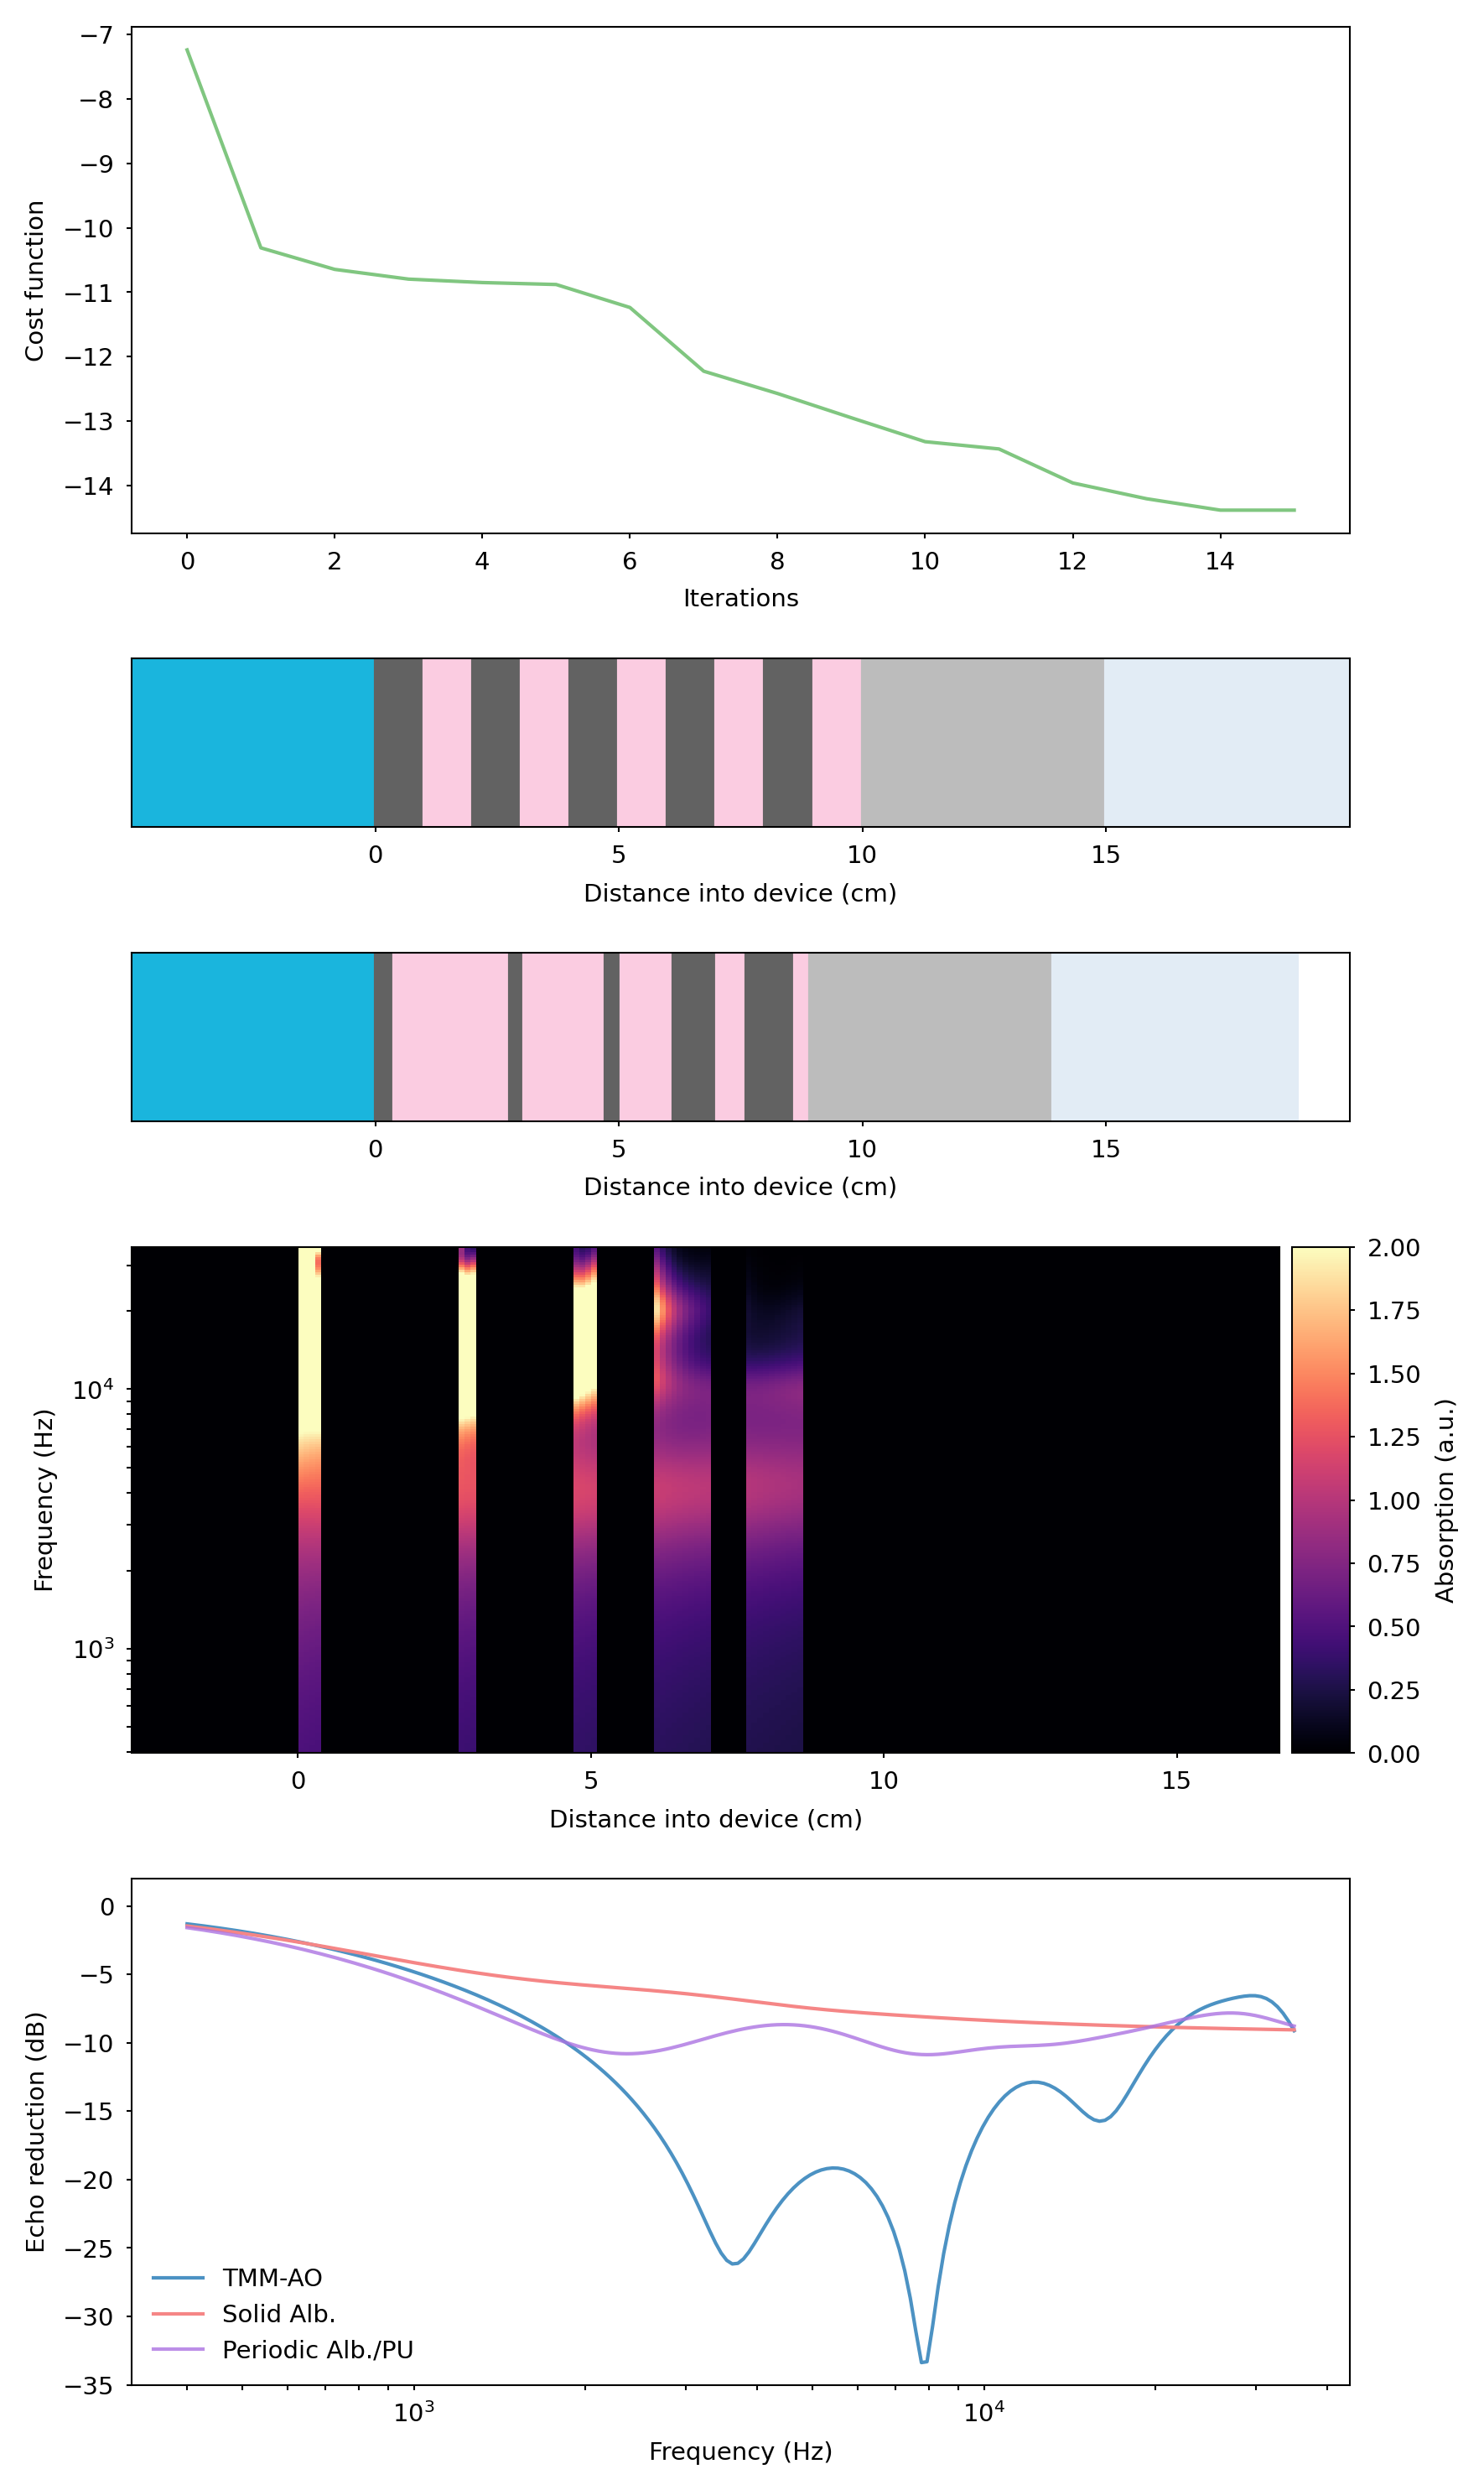

In [8]:
'''
#Pretend several days have passed, and we want to analyze Larry. We'll need to first load the old pickle the optimization generated. If you're doing analysis right after optimization, you DO NOT need to do the following 3 commands; they are only
#necessary if you're doing analysis on old data.
ad=agnostic_director()#Instantiate agnostic_director, which inherits all of agnostic_analysis's methods/attributes.
ad.set_physics(physics_package=acoustics_tmm,mat1Call=materials_library.alberich_tile,mat2Call=materials_library.polyurethane,param0Call=materials_library.water,paramNCall=materials_library.air,customInputCall=sonar_Iin)#Load physics
ad.load_evo(name='larry',dir='/aDrive/afolder/') #Load Larry's pickle, which we stored in '/aDrive/afolder/' during optimization. Now, ad.evo is identical to the ad.evo from Larry's optimization, as if we had just now finished the optimization.
'''

#Starting here, the proceedure is the same whether you're using an imported evo or one from an optimization you just performed.
#I want to make sure I'm analyzing my data properly, so I want to know the settings I used during optimization, like the scale I used for my optParams/simPoints, the materials functions I used, etc. If you want to retrieve this info, call
ad.print_evo_info(sparse=True) #This prints the evo preamble and some other statistics to console. If sparse=True, less information will be provided. This function does nothing but prints ad.evo[-1] and some other stuff in a more readable format

#First, let's take a look at the integrated echo reduction, before plotting the instantaneous, frequency-dependent ER. I promised you 15.2dB, and you're going to get it!

#Initialize parameters analysis simulation. Most of these parameters are recycled from ad.set_structure and ad.run_optimization.
ad.init_analysis(simRange=[1000,10000], #The simulation range. The ER will be integrated over whatever range you enter here, so let's keep it 1kHz-10kHz.
                 simResolution=200, #The number of simulation points. We wanted to use as few points as we could get away with during optimization to minimize simulation time. That's not an issue for analysis, so let's crank it up for smoother plots.
                 simScale=1, #The simulation scale. I'm working with frequency in Hz, so already SI.
                 simType='independent', #Using 'independent' mode again. I can't think of any reason you would use a different mode for analysis than you did for optimization, but you could theoretically do it with some massaging of ad.evo.
                 third_variables=[{'temperature':25,'pressure':1,'humidity':1}], #Let's keep the same third variable parameters. Again, these are for the air in the sub; the seawater model is different.
                 logSim=True, #Let's keep the simulation points logarithmically distributed
                 substrates=[{'material_call':materials_library.steel4340,'thickness':0.05}],superstrates=[], #We still need the sub's hull
                 num_layers=None) #The number of sublayers within each interval if simType=='fixedPoint'. Irrelevent here.


#Anything that could be classified as a response of a device is known as an "indicator". Each physics package has a .indicators() method with a list of valid indicator names. All the indicators we ask for are stored in ad.indicator_dict.
ad.get_indicatorsEvo(['RIInt'],#Let's grab the integrated echo reduction ('RLInt'). acosutics_tmm.indicators() knows what this means
                     2,0)#For the final structure

#Now for the custom structures. Their indicators will be added to ad.indicator_dict
ad.get_indicatorsCustom(['RIInt'], #Let's get the same for solid Alberich tile.
                        [0.1], #We have exactly one x-value (10cm) in our custom structure
                        [1],#We have exactly one x-value (1), indicating 100% Alberich.
                        'solid') #And let's name these datasets 'solid'
ad.get_indicatorsCustom(['RIInt'],[0.1/10]*10,[1,0]*5,'gap') #And let's get the same for the periodic multilayer, calling it "gap"

#Now, we have two kinds of indicators in ad.indicator_dict. We have one 'RIInt' for each of the invDes device, the 'solid' device, and the 'gap' device. This is a _scalar indicator_; the "dataset" is just one number. To display all scalar indicators, we call
ad.print_scalarIndicators()#This will display the value of each scalar. 15.2dB, as promised!

#Now, let's do some plotting. It would be nice to see beyond just 1kHz and 10kHz, so let's re-initialize the analysis with a broader sim range
ad.init_analysis(simRange=[400,35000], #The simulation range. Let's broaden it a bit to see how the device is doing outside the target spectrum
                 simResolution=200,simScale=1,simType='independent',third_variables=[{'temperature':25,'pressure':1,'humidity':1}],logSim=True,substrates=[{'material_call':materials_library.steel4340,'thickness':0.05}],superstrates=[],num_layers=None) #Everything else stays the same

#Initialize our multiplot. The arguments passed to this function are the "global" settings, which apply to the whole pyplot figure.
ad.init_plot(save_name='larryTableau', #The name of the output plot, minus extension
             save_dir='/aDrive/adifferentfolder/', #Where to save the output plot.
             save=False, #Whether to save the output plot. Again, I'm assuming you do not have the above path on your computer, so let's not do that.
             show=True, #Whether to have pyplot display the output plot
             size=(6,10), #The size of the pyplot figure; first argument is width, second height
             dpi=300, #dpi of the output figure
             dark=False, #A quick way to apply a dark theme: white text, axes, etc. Could also change each color individually, but this is cumbersome
             savetype='.png', #Filetype of output plot. Supports any filetype that pyplot does.
             bbox_inches=None, #If this were a Bbox object, it would cause pyplot to save only the requested portion of the plot. We want all of it, so it's best not to touch this setting.
             tight_layout=True, #Apply tight layout. This should always be done unless pyplot is severely misbehaving
             subplots_adjust={'left':None,'right':None,'top':None,'bottom':None,'hspace':None,'wspace':None}, #Padding along the boarders of the figure and between subplots. See pyplot.subplots documentation. We're not going to touch it here.
             sharex=False, #Whether to have all your plots have the same x-axis. We don't want that
             height_ratios=[3,1,1,3,3]) #Relative height of each subplot. We want them all the same, except for the structure plots which can be 1/3 the height of the rest.

#We now add subplots in the order we wish them to appear. Let's put the cost function at the top. There are a ton of optional arguments. We're going to leave most of them as their defaults.
ad.add_subplotCostFunction(plot_grand_iters=False, #If True, displays a red dot at the start of each grand iteration.
                           lineColor='C2', #Color of the cost function. This could be any named color or a hex code. We're using C2, a dignified green worthy of Larry.
                           linestyle='-', #Style of the line. We're sticking with a solid line.
                           linewidth=1, #Width of the line. We're using 1 point.
                           axiswidth=0.5, #Width of the axis. Pyplot axes tend to be rather generously proportioned, so let's tune it down to 0.5 points.
                           tickwidth=0.5, #Width of the ticks. Usually the same as the axis width
                           ticklength=1.5, #Length of the ticks. Pyplot likes long ticks. I don't. Let's shorten them.
                           xlabel='Iterations', #The x-axis label.
                           ylabel='Cost function', #The y-axis label.
                           labelfontsize=7, #Size of the axis label font in points. Seven should do it.
                           tickfontsize=7, #Size of the tick label font in points. Seven should do it.
                           logy=False, #Whether to do a semilog plot on y. Let's do it to show off more of the cost function. Note that pyplot will cry if you try and do logscale on negative or zero values.
                           grand_iterations=[1], #Which grand iterations to plot. We had a one-element discretization map. This means ad.evo has keys -1,0,1,2. -1 is the preamble, nothing to plot. 0 is ONLY the initial condition. 2 is ONLY the final
                                                   #structure. We're only interested in what happened during optimziation, so let's just plot 1. If I left this blank, it would default to [0,1,2].
                           alpha=0.6) #Alpha value to apply to the color of the plot line. 0.6 makes C2 a pleasant algal green.

#Let's do the structure plots next. Our inverse design looks pretty funky, and we want everyone to know it. What better way than to juxtapose it with a boring rational design? Let's add a custom structure subplot.
ad.add_subplotStructure(custom_x=[0.1/10]*10, #Let's make it a 10-layer, 10cm thick device with the layers having uniform thickness
                        custom_y=[1,0]*5, #Let's alternate Alb. and PU
                        labelfontsize=7, #Let's keep the fonts consistent
                        tickfontsize=7,
                        noYticks=True, #The y-axis isn't really telling us anything, so let's turn off the y-axis tick marks
                        color1='#fbcce1', #Let's make PU pompous pink
                        color2='#626262', #and Alb. gloomy grey.
                        yscale=1, #This number will scale the y-axis. No reason to do it since y-axis isn't telling us anything, so let's keep it at 1.
                        xscale=100, #This number will scale the x-axis. Let's work in cm
                        xlabel='Distance into device (cm)', #x-axis label
                        ylabel=None, #We don't need or want a y-axis label
                        substrates=[(0.05,1,'#bcbcbc')], #Let's add our steel hull in ghastly grey
                        incident_pad=[0.05,1,'#1ab5ddff'], #We don't want the plot to start exactly where the device does. We want to show a bit of the incidence medium. 5cm of it to be exact.
                        transmission_pad=[0.08,1,'#e2ecf5'], #Let's show the same amount of transmission medium.
                        xlims=[-5,20], #Let's plot from 5cm inside the incidence medium to 5cm inside the transmission medium. Remeber to add 5cm for the hull!
                        noXticks=False, #We do want x-ticks
                        axiswidth=0.5,tickwidth=0.5,ticklength=1.5,
                        xticklocations=[0,5,10,15]) #Pyplot puts its ticks in the darndest places. Let's do a manual override.

#That's all well and good, but we're really here for the invDes. Let's plot our final inverse designed structure.
ad.add_subplotStructure(grand_iteration=2, #The final structure is stored in both the last entry of grand iteration 1, and the only entry in grand iteration 2. GI2 is the easier place to find it
                        iteration=0, #There is only one "iteration" in GI3, and it is the final structure.
                        #Everything else will be identical to our custom structure plot.
                        labelfontsize=7,tickfontsize=7,noYticks=True,color1='#fbcce1',color2='#626262',yscale=1,xscale=100,xlabel='Distance into device (cm)',ylabel=None, substrates=[(0.05,1,'#bcbcbc')],incident_pad=[0.05,1,'#1ab5ddff'],
                        transmission_pad=[0.05,1,'#e2ecf5'],xlims=[-5,20],noXticks=False,axiswidth=0.5,tickwidth=0.5,ticklength=1.5,xticklocations=[0,5,10,15])


#Now we can admire Larry's grandure and laugh at the pathetic rationality of the periodic multilayer. But what's actually happening inside Larry? Let's plot the absorption distribution to find out
ad.add_subplotFields(grand_iteration=2,iteration=0, #We want the final structure
                     yscale=1,xscale=100, #Let's keep the simulation scales in our plots.
                     resolution=200, #Let's sample the field at 200 points through the depth of the device
                     zlims=[None,2], #We have some areas of the plot with very high absorption because Larry is awesome. Let's satruate the color scale for better contrast in the parts we care about
                     colorbarLabel='Absorption (a.u.)', #Label on the colorbar axis
                     xlabel='Distance into device (cm)', #Label on the x-axis
                     ylabel='Frequency (Hz)', #Label on the y-axis
                     logy=True, #Let's log the frequencies
                     labelfontsize=7,tickfontsize=7,axiswidth=0.5,tickwidth=0.5,ticklength=1.5, #Keep the same font/axis parameters
                     physicsPackageArg=[1E5,'absorption'], #These arguments are passed to the interpolate method in the physics package, which knows how to handle them. The first element will be used by the package to scale the absorption magnitude.
                                                           #The second tells it to compute the absorption, as opposed to 'pressure' or something else like that.
                     leftPad=0.2,rightPad=0.2, #Like the structure plots, we want to see some of the incidence/transmisison medium. Let each be 20% the width of the device.
                     contourf=False, #Whether to use pyplot.contourf (if True) or pyplot.pcolormesh (if False)
                     colormap='magma', #Let's use the magma scheme because it looks cool.
                     colorbarNorm='linear', #Let's use a linear scale for the colorbar
                     xticklocations=[0,5,10,15]) #And let's keep the same tick locations as in the structure plots.

#Last thing we want to see is the response of the device. Let's throw in the response of solid Alberich and that periodic multilayer for comparison.
ad.get_indicatorsEvo(['RLInst'],#Let's grab both the instantaneous echo reduction ('RLInst'). acosutics_tmm.indicators() knows what this means
                     2,0)#For the final structure

#Now for the custom structures. Their indicators will be added to ad.indicator_dict
#The second type of indicator is a _vector indicator_, such as 'RIInst' for each of the three devices. Their datasets are vectors - in this case, 200-element vectors, one instantaneous echo reduction per frequency simulation point.
ad.get_indicatorsCustom(['RLInst'], #Let's get the same for solid Alberich tile.
                        [0.1], #We have exactly one x-value (10cm) in our custom structure
                        [1],#We have exactly one x-value (1), indicating 100% Alberich.
                        'solid') #And let's name these datasets 'solid'
ad.get_indicatorsCustom(['RLInst'],[0.1/10]*10,[1,0]*5,'gap') #And let's get the same for the periodic multilayer, calling it "gap"

#To see these, we need to plot them.
#Before that, though, let's customize the lines which will represent our three devices. We're going to need to define these dictionaries to do that. Each dictionary should have the same keys as in ad.indicators_dict
datasetlabels={"RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, [2, 0]": 'TMM-AO', "RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, solid": 'Solid Alb.',"RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, gap":'Periodic Alb./PU'} #Let's give each set a shorter name in the legend
linewidths={"RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, [2, 0]": 1, "RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, solid": 1,"RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, gap":1}#And give them the correct linewidths
linecolors={"RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, [2, 0]": 'C0', "RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, solid": '#f58686',"RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, gap":'#ab73e1'} #And some swanky colors
linestyles={"RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, [2, 0]": '-', "RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, solid": '-',"RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, gap":'-'} #And make them all solid
alphas={"RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, [2, 0]": 0.8, "RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, solid":1,"RLInst, {'temperature': 25, 'pressure': 1, 'humidity': 1}, gap":0.8} #And add a bit of transparency

#Now we can generate the indicators subplot. Don't worry about the fact that there are still scalar indicators in ad.indicator_dict alongside our vector indicators; ad is smart enough to ignore them when plotting.
ad.add_subplotIndicators(ad.indicator_dict, #Use our indicator_dict
                         lineColors=linecolors,linestyles=linestyles,linewidths=linewidths,datasetLabels=datasetlabels,alphas=alphas, #Apply the customization dictionaries we just defined
                         labelfontsize=7,tickfontsize=7,legendfontsize=7,axiswidth=0.5,tickwidth=0.5,ticklength=1.5,
                         xlabel='Frequency (Hz)',ylabel='Echo reduction (dB)', #Set the axis labels
                         legend=True, #We've got two lines going on, so let's put a legend on this one
                         legendframe=False, #Let's ditch the legend frame
                         legendlocation='lower left', #And stick it in the upper left to get it out of the way
                         ylims=[-35,2]) #Let's give the plot a bit more breathing room
                         #Note that the x-axis will automatically by loged because we set logSim=True in init_analysis()

#Now all that's left to do is take a look.
ad.get_plot()

###Conclusion
---
And that's all there is to it! As a recap, to run an optimization with agnostic_director:


*   `ad=agnostic_director()` to instantiate
*   `ad.set_physics()` to load the physics package and material functions
*   `ad.set_optimizerFunctions()` to load the schedulers
*   `ad.set_structure()` to initialize the device
*   `ad.run_optimization()` to run the optimization

When this is done, everything you need to know about the final structure and the optimization process lives in `ad.evo`.

To load data from an old optimizaiton for analysis:

*   `ad=agnostic_director()` to instantiate
*   `ad.set_physics()` to load the physics package and material functions
*   `ad.load_evo()` to load the old `ad.evo` object.
*   `ad.print_evo_info()` to see what optimization parameters were used in the old optimization

To do some analyzing:

*   `ad.init_analysis()` to set up the analysis simulations
*   `ad.init_plot()` to initialize the multiplot
*   `ad.get_indicatorsEvo()` to compute the response of the final or intermediate structure
*   `ad.get_indicatorsCustom()` to compute the response of a custom structure
*   Add whatever subplots you want in the order you want them to appear
    *     `ad.add_subplotCostFunction()` to add a cost function subplot
    *     `ad.add_subplotStructure()` to add a structure subplot
    *     `ad.add_subplotFields()` to add a fields subplot
    *     `ad.add_subplotIndicators()` to add an indicators subplot
*   `ad.get_plot()` to show/save the multiplot

Hope this was helpful! There are a ton of options I didn't cover in this or the other two examples. Be sure to check the docs if you're curious.

